### So many libraries!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   KBinsDiscretizer,
                                   MinMaxScaler)
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Read in the data

In [2]:
df = pd.read_csv('./data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Manipulate the data for training.

* Use Sklearn to split data into Training data and Validation data. Validation size = test_size
* Create 2 DataFrames (1 for everything except 'Survived', the other only has 'Survived')
* This enables us to separate the 'answer' from the features used to find the 'answer.'

In [3]:
X = df.drop('Survived', axis=1)
y = df[['Survived']]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 10)

* Train shapes should match, val shapes should match

In [5]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 11), (179, 11), (712, 1), (179, 1))

* Bring the Training Data features and 'answer' together for training.
* Do the same for the validation data

In [6]:
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

### EDA

* I will need to take care of the Age, Cabin and Embarked nan values somehow.
* In this notebook, I decided to include imputation in my column transformer.

In [7]:
df_train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            135
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          554
Embarked         2
Survived         0
dtype: int64

* Graphing survivors vs. deaths

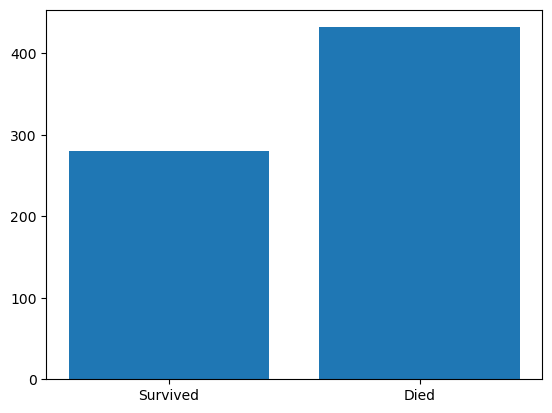

In [8]:
survived = df_train['Survived'].value_counts()[1]
died = df_train['Survived'].value_counts()[0]
labels = ['Survived', 'Died']
height = [survived, died]

plt.bar(labels, height)
plt.show()
plt.close();

In [9]:
# Checking the ratio of Class 1 passengers vs. survivors of Class 1
class1 = df_train['Pclass'].value_counts()[1]

class1_survive = df_train.loc[df_train['Survived'] == 1]
class1_survive = class1_survive.loc[class1_survive['Pclass'] == 1]
class1_survive = class1_survive['Pclass'].value_counts()[1]

class1_ratio = class1_survive / class1
class1_ratio
# Roughly 62% of Class 1 passengers survived
# Q: How do the other 2 look?

0.6235294117647059

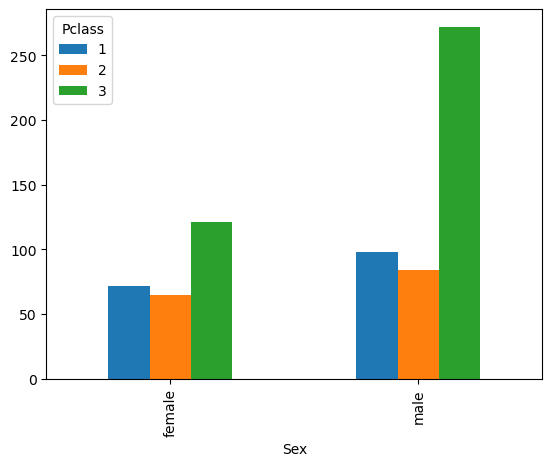

In [10]:
df_train.groupby(['Sex', 'Pclass']).size().unstack(level=1).plot(kind='bar')
plt.show()
plt.close();

#### What is the average age of passengers?
#### How do the ages of survivors compare to the ages of those who died?

In [11]:
survived_total = df_train.loc[df_train['Survived']==1]['Age']
died_total = df_train.loc[df_train['Survived']==0]['Age']

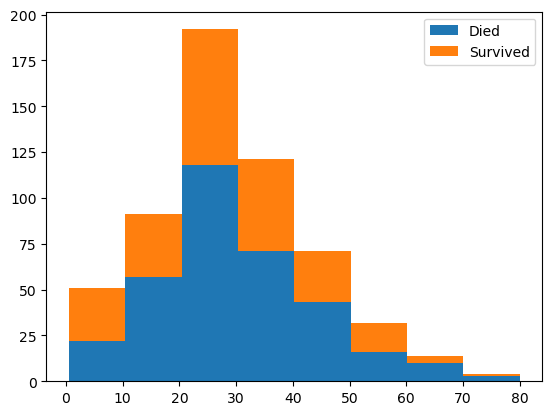

In [12]:
#Plotting these totals to compare visually
fig = plt.figure()

plt.subplot(111)
plt.hist([died_total, survived_total],
         bins=8,
         range=(0.5, 80),
         stacked=True)
plt.legend(('Died', 'Survived'), loc='best')
plt.show()
plt.close();

#### We can see that Sex and Passenger class heavily influence whether a passenger survived.

In [13]:
train_group_by = pd.DataFrame(df_train.groupby(['Sex', 'Pclass', 'Survived'])['Survived'].count())
train_group_by

Survived
Sex    Pclass Survived          
female 1      0                2
              1               70
       2      0                6
              1               59
       3      0               60
              1               61
male   1      0               62
              1               36
       2      0               70
              1               14
       3      0              232
              1               40

### Making the Logistic Regression

* We begin by using only one feature.

In [14]:
# Define variables for later use
X = df_train[['Pclass']]
y = df_train['Survived']

X.shape, y.shape

((712, 1), (712,))

In [15]:
# Start the model
model_LR = LogisticRegression()
model_LR.fit(X, y)

LogisticRegression()

In [16]:
# Checking the weights and bias used in the logical regression formula
w_1 = model_LR.coef_[0]
w_0 = model_LR.intercept_
print(f'Model feature coefficient : {w_1}\nModel intercept/bias: {w_0}')

Model feature coefficient : [-0.79538448]
Model intercept/bias: [1.37307183]


In [17]:
# Seeing what the predictions from this model are
y_pred = pd.DataFrame(model_LR.predict(X))
y_pred

,0
0,0
1,0
2,0
3,1
4,0
...,...
707,1
708,0
709,1
710,0


In [18]:
# Testing the model vs. validation data
# We can do better...
X_val = df_val[['Pclass']]
print(f'train: {model_LR.score(X,y)}, test: {round(model_LR.score(X_val,y_val),3)}')

train: 0.6657303370786517, test: 0.732


#### Checking Probability compared to changing threshold

* Here we are finding the exact probabilities that a given passenger will survive or not.
* These values are split by default on 0.5
- If the probability is higher than 0.5 the model will predict a 1, i.e. survived.

In [19]:
X_val2 = df_val[['Pclass']]

estim_prob = model_LR.predict_proba(X_val2)
estim_prob = estim_prob.round(3)
estim_prob = pd.DataFrame(data=estim_prob, columns=model_LR.classes_)
estim_prob

,0,1
0,0.734,0.266
1,0.734,0.266
2,0.734,0.266
3,0.359,0.641
4,0.359,0.641
...,...,...
174,0.359,0.641
175,0.554,0.446
176,0.734,0.266
177,0.734,0.266


* Any threshold between ~.4 - .6 results in around a 73% accuracy.

In [20]:
threshold = 0.63 #<--- Change threshold here
pred = []
for item in estim_prob[1]:
    if item >= threshold:
        pred.append(1)
    else:
        pred.append(0)

estim_prob['prediction']=pred

In [21]:
# Calculate if this Threshold improves or not
((y_val.reset_index(drop=True)['Survived'] == estim_prob['prediction']).sum())/y_val.shape[0]

0.7318435754189944

### Trying out multiple features

In [22]:
X1 = df_train[['Pclass', 'Fare']] # Optimally, use other features, but they need to be transormed 
y1 = df_train['Survived']
X1_val = df_val[['Pclass', 'Fare']]
X1.shape, y1.shape

((712, 2), (712,))

In [23]:
model_2_feats = LogisticRegression()
model_2_feats.fit(X1, y1)

LogisticRegression()

* Hm...doesn't seem to have improved. Let's do more.

In [24]:
print(f'train: {model_2_feats.score(X1,y1)}, test: {round(model_2_feats.score(X1_val,y_val),3)}')

train: 0.6657303370786517, test: 0.732


### Feature Engineering

In [25]:
print(df_train.dtypes)
df_train.head()

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived         int64
dtype: object


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
57,58,3,"Novel, Mr. Mansouer",male,28.5,0,0,2697,7.2292,NaN,C,0
717,718,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27.0,0,0,34218,10.5000,E101,S,1
431,432,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1000,NaN,S,1
633,634,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S,0
163,164,3,"Calic, Mr. Jovo",male,17.0,0,0,315093,8.6625,NaN,S,0


### What are our data types

* PassengerId is categorical
* PClass is categorical
* Name is categorical
* Sex is binary (in this case)
* SibSp is categorical
* Parch is categorical
* Ticket is categorical
* Fare is metric
* Cabin is categorical
* Embarked is categorical
* Survived is binary

### How should we transform them?

* Drop unneeded columns
* OHE Pclass
* I decided to Bin Fare and Age in an effort to help the model learn groupings more efficiently.
- IMPUTE AND BIN Fare
- IMPUTE AND BIN Age
* IMPUTE AND OHE Embarked

* For the purpose of learning, I decided to start with a simple approach and see how the predictions fared.
* I could use Cabin as well, but with so many Nan values, it is a little too much work for this simple model.
* I left PassengerID in the prediction only for the purpose of easily assigning who is who.

In [26]:
df_train = df_train.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Survived'], axis=1)

In [27]:
df_train

,PassengerId,Pclass,Sex,Age,Fare
57,58,3,male,28.5,7.2292
717,718,2,female,27.0,10.5000
431,432,3,female,NaN,16.1000
633,634,1,male,NaN,0.0000
163,164,3,male,17.0,8.6625
...,...,...,...,...,...
369,370,1,female,24.0,69.3000
320,321,3,male,22.0,7.2500
527,528,1,male,NaN,221.7792
125,126,3,male,12.0,11.2417


In [28]:
# Create pipeline for imputing and OHE
impute_and_ohe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False))               

In [29]:
# Create pipeline for imputing and binning
impute_and_binning = make_pipeline(SimpleImputer(strategy='median'), KBinsDiscretizer(encode='onehot-dense'))

In [30]:
# Creating a column transformer
trans = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Pclass']),
    ('i_o', impute_and_ohe, ['Sex']),
    ('i_b', impute_and_binning, ['Age', 'Fare']),
], remainder='passthrough')
trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Pclass']),
                                ('i_o',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['Sex']),
                                ('i_b',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='onehot-de

In [31]:
# Fitting this transformer to the training data and then transforming
trans.fit(df_train)
df_train_tran = trans.transform(df_train)
pd.DataFrame(data=df_train_tran)

/Users/briana/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,58.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,718.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,432.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,634.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,370.0
708,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,321.0
709,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,528.0
710,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,126.0


In [32]:
# Create a new Logtistical Regression model, fitting to the transformed training data
model_trans = LogisticRegression()
X3 = df_train_tran
y = y # Above y = df_train['Survived']
model_trans.fit(X3, y)

LogisticRegression()

* Our score improved slightly!

In [33]:
# Checking score of training data
round(model_trans.score(X3,y),3)

0.794

### Let's test out our model on Validation Data

In [34]:
# Transforming validation data into the correct format
df_val = df_val.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Survived'], axis=1)

In [35]:
df_val_tran = trans.transform(df_val)
pd.DataFrame(data=df_val_tran)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,591.0
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,132.0
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,629.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,196.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,231.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,457.0
175,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,192.0
176,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,604.0
177,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,95.0


In [36]:
# Checking score of validation data
round(model_trans.score(df_val_tran,y_val),3)

0.832

In [37]:
# Seeing my final predictions of validation data
val_pred = pd.DataFrame(model_trans.predict(df_val_tran))
val_pred

,0
0,0
1,0
2,0
3,1
4,1
...,...
174,0
175,0
176,0
177,0


# Checking if a Random Forest would improve performance or not

* It turns out that it scores about the same.

In [38]:
rf = RandomForestClassifier(n_estimators=50, max_depth=2)
rf.fit(X3, y) # Same variables used to fit the earlier Logistical Regression
rf.score(df_val_tran, y_val)

0.8324022346368715

# Test data time!

* I decided to skip right to using the transformer

In [39]:
test = pd.read_csv('./data/test.csv')

In [40]:
test_tran = trans.transform(test)
test_tran = pd.DataFrame(data=test_tran)

* Here I am assigning the passenger ID to its corresponding column.

In [41]:
test_tran_id = test_tran[14]

* We append the two DataFrames and the survived column and rename the columns as Kaggle wants

In [42]:
final_pred = pd.DataFrame(model_trans.predict(test_tran))
final_pred = pd.merge(test_tran_id, final_pred, left_index=True, right_index=True)

In [43]:
final_pred.rename(columns={14: 'PassengerId', 0: 'Survived'}, inplace=True)

In [44]:
final_pred['PassengerId'] = final_pred['PassengerId'].astype(int)
final_pred

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [45]:
final_pred.to_csv('./data/first_prediction.csv', index=False)

# This submission achieved %75.8 accuracy.